# Niyati's Sleep Analysis
Niyati's sleep data from Feb, 1 to May, 31 as collected by her Fitbit  

**Objectives**: 
1. Gain insight into Niyati's Sleeping patterns
2. Learn to use and implement python's statistical tools

Questions I'm trying to answer:
* General data collection. 
    1. How long does she normally sleep? 
    2. When does she go to bed? etc.

* Getting more insight.
    1. Using the collected data, can we speculate what the ideal sleep period can be?
    2. What should be the ideal bedtime?

* Sleep Stages.
    1. How does the amount of sleep affect the quality of sleep?

In [41]:
#import relevant librabries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import requests
from bs4 import BeautifulSoup as bs
import seaborn as sns
import datetime as dt
from matplotlib import gridspec
from matplotlib import dates
from scipy.stats import linregress
from scipy import stats

In [42]:
sleep=pd.read_csv('niyatisleep.csv',header=0)
sleep=sleep.dropna(axis=0, how='any')
print(sleep.shape)
sleep.keys()

(105, 9)


Index(['Start Time', 'End Time', 'Minutes Asleep', 'Minutes Awake',
       'Number of Awakenings', 'Time in Bed', 'Minutes REM Sleep',
       'Minutes Light Sleep', 'Minutes Deep Sleep'],
      dtype='object')

## Data imported from Fitbit:
``` python 
['Start Time', 'End Time', 'Minutes Asleep', 'Minutes Awake','Number of Awakenings',
 'Time in Bed', 'Minutes REM Sleep','Minutes Light Sleep', 'Minutes Deep Sleep']
```

However, this data needs to be cleaned before we can apply some features.

Here we convert the timestamps into python's datetime objects, sort the data chronologically, define days of the week and assign a timecode to sleep time and wake time.

In [43]:
# Convert Start time and End time into python compatible datetime entries
sleep['Start Time']=[dt.datetime.strptime(sleep.loc[i,'Start Time'],'%Y-%m-%d %I:%M%p') for i in sleep.index]
sleep['End Time']=[dt.datetime.strptime(sleep.loc[i,'End Time'],'%Y-%m-%d %I:%M%p') for i in sleep.index]
#chronological sort
sleep=sleep.sort_values(by='Start Time')
#Define Days of the week
sleep['Day']=[sleep.loc[i,'End Time'].strftime('%A') for i in sleep.index]
#Adding time objects
sleep['Sleep Time']=[sleep.loc[i,'Start Time'].time() for i in sleep.index]
sleep['Wake Time']=[sleep.loc[i,'End Time'].time() for i in sleep.index]

### A sample of the data available from Fitbit and additional data extracted for analysis

In [44]:
sleep.head(5)

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep,Day,Sleep Time,Wake Time
28,2018-02-01 00:15:00,2018-02-01 07:29:00,376,58,26,434,115.0,159.0,102.0,Thursday,00:15:00,07:29:00
27,2018-02-02 00:36:00,2018-02-02 07:02:00,323,63,25,386,36.0,229.0,58.0,Friday,00:36:00,07:02:00
26,2018-02-03 00:36:00,2018-02-03 08:33:00,434,43,21,477,96.0,253.0,85.0,Saturday,00:36:00,08:33:00
25,2018-02-04 01:42:00,2018-02-04 09:12:00,378,72,26,450,109.0,199.0,70.0,Sunday,01:42:00,09:12:00
24,2018-02-04 23:05:00,2018-02-05 07:06:00,428,53,28,481,121.0,190.0,117.0,Monday,23:05:00,07:06:00


In [45]:
daymean=sleep.groupby(['Day']).mean()['Minutes Asleep']
daymedian=sleep.groupby(['Day']).median()['Minutes Asleep']
daydev=sleep.groupby(['Day']).std()['Minutes Asleep']

## Sleep according to the day of the week

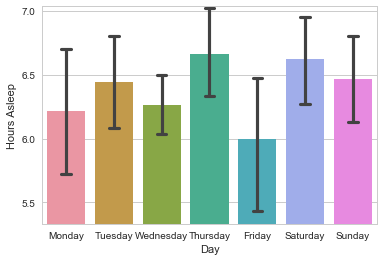

In [46]:
sns.set_style("whitegrid")
daysorder=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
ax = sns.barplot(x='Day',y='Minutes Asleep',capsize=0.2,order=daysorder,data=sleep)
axis=ax.axes
axis.set_ylim(320,422)
hourticks=np.array([330+30*i for i in range(4)])
axis.set_yticks(hourticks)
axis.set_yticklabels(hourticks/60)
axis.set_ylabel('Hours Asleep')
plt.savefig('daysleep.png', bbox_inches='tight')

<img src="daysleep.png" alt="Barplot of sleep vs Day of the week" class="center">
There is no significant predictable variation in hours asleep depending on the day of the week. The lack of a 9-5 work schedule is primarily resposible for the lack of the typical sleeping pattern of less sleep during weekdays and more during weeekends. Median hours asleep fall in a tight 30 minute window.

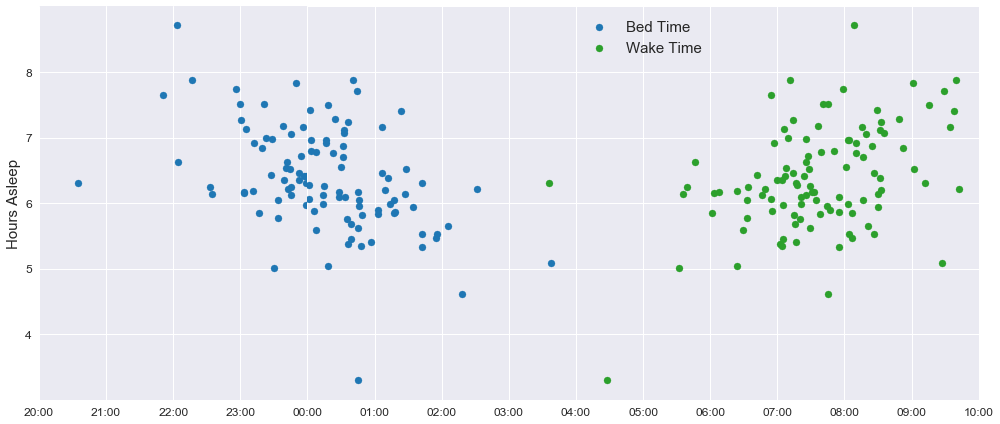

In [47]:
f=plt.figure(figsize=(14,6))
sns.set_style("darkgrid")
gs = gridspec.GridSpec(1,2,wspace=0.0, width_ratios=[4, 10]) 
ax= plt.subplot(gs[0,0])
ax.scatter(list(sleep['Sleep Time']),sleep['Minutes Asleep']/60,color='tab:blue',label='Bed Time')
ax.set_xlim([dt.time(20, 0), dt.time(23,59,59)])
ax.set_xticks([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)])
ax.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)])
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim([3,9])
ax.set_yticks(range(4,9))
plt.xlabel('')
ax.set_ylabel('Hours Asleep', fontsize=15)
ax2=plt.subplot(gs[0,1])
ax2.scatter(list(sleep['Sleep Time']),sleep['Minutes Asleep']/60,color='tab:blue',label='Bed Time')
ax2.scatter(list(sleep['Wake Time']),sleep['Minutes Asleep']/60,color='tab:green',label='Wake Time')
ax2.set_xlim([dt.time(0, 0), dt.time(10,0)])
ax2.set_ylim([3,9])
ax2.set_xticks([dt.time(i, 0) for i in range(11)])
ax2.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(11)])
ax2.set_yticklabels([])
ax2.tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='upper center',fontsize=15)
plt.xlabel('')
plt.tight_layout()
plt.savefig('hoursawake.png', bbox_inches='tight')

## Bedtime and Waketime distribution
<img src="hoursawake.png" alt="distribution of bettime and waketime" class="center">
<center>There is a clear inverse relationship between the bedtime and hours asleep. The earlier you sleep, you end up actually sleeping more than you usually would. The ideal bedtime window lies between 11PM and 1AM, which will most likely end up providing the necessary 6-7 hours of sleep. 'Waking up' most likely is a function of bedtime and hours of sleep required; Niyati doesn't really use an alarm to wake up on most days which might explain the wider variation.</center>

<h3> <center> Quantifying Bed time </center> </h3>
Time was converted to minutes from midnight whichallowed me to run a regression analysis on Bed time.

In [48]:
time=pd.DataFrame()
time['Hours Asleep']=sleep['Minutes Asleep']/60
time['Sleep Time']=sleep['Sleep Time']
time['minutes']=0
for i in time.index:
    time.loc[i,'minutes']=time.loc[i,'Sleep Time'].hour*60+time.loc[i,'Sleep Time'].minute
    if time.loc[i,'minutes']>1000:
        time.loc[i,'minutes']=time.loc[i,'minutes']-24*60

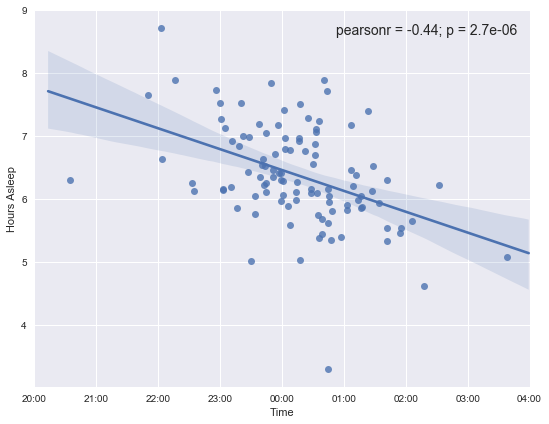

In [49]:
sns.set_style("darkgrid")
g = sns.JointGrid(x="minutes", y="Hours Asleep", data=time, ratio=100)
g.plot_joint(sns.regplot)
g.annotate(stats.pearsonr,fontsize=14)
g.ax_marg_x.set_axis_off()
g.ax_marg_y.set_axis_off()
plt.xticks([-240+60*i for i in range(9)]);
g.set_axis_labels('Time', 'Hours Asleep')
g.fig.set_figheight(6)
g.fig.set_figwidth(8)
g.ax_joint.set_xticklabels([dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(20,24)]+
                           [dt.time.strftime(dt.time(i, 0),'%H:%M') for i in range(5)]);
plt.savefig('bedtimeregression.png', bbox_inches='tight')

<img src='bedtimeregression.png' alt='Regression analysis on bedtime' class='center'>
Pearson correlation points to the previously hypothesized inverserelationship between bedtime and sleep duration. Even though the R value is relatively low due to the variation in data, P value significantly smaller than 0.05 does suggest that null hypothesis is certainly false, i.e. a strong correlation exists between Bed time and hours of sleep.

<h2> Sleep Stages </h2>
Sleep can be broken down into 4 stages:  
### 1. Awake
You are awake in bed ready to fall asleep or something disturbs you during the night like the room being too cold or too hot. This usually accounts for about an hour of the total time you're in bed.  
### 2. Light Sleep
Light sleep accounts for about 50% of your total sleep. It’s when your body processes memories and emotions and your metabolism regulates itself. So there’s a lot of body maintenance occurring during lighter stages of sleep. Breathing and heart rate typically decrease slightly during this stage.

<h2> Sleep Stages </h2>
Sleep can be broken down into 4 stages:  
### 3. Deep Sleep
During deep sleep, you become less responsive to outside stimuli. Breathing slows and muscles relax; heart rate usually becomes more regular. Your muscles are very relaxed. You’re not dreaming at all during this time. Your body is doing a lot of rebuilding and repairing. Deep sleep is when your body secretes growth hormone, which is associated with cellular rebuilding and repair.  
### 4. REM Sleep (Rapid Eye Movement)
If deep sleep is about body, REM is about the brain. The brain is very active during REM sleep, yet the body is very inactive. REM is when most dreaming happens and your eyes move rapidly in different directions. Heart rate increases and your breathing becomes more irregular. REM is very important for emotion regulation and memory; you’re clearing the brain of things that aren’t needed. It’s also the peak of protein synthesis at the cellular level, which keeps many processes in the body working properly.

## Sleep Stages
For the best, most rejuvinating night of sleep, we need to maximmize the time we spend in Deep Sleep and REM Sleep. From our previous analysis we found 6-7 hours to be the ideal sleep time for Niyati. So how does that compare to the quality of sleep?  
To Understand that, we've broken the data into 3 tranches; 
   * below 6 hours, 
   * between 6-7 hours and 
   * above 7 hours  

to identify which days she slept less or more than ususal.

In [50]:
stage=pd.DataFrame()
stage['REM']=sleep['Minutes REM Sleep']/sleep['Time in Bed']*100
stage['Light']=sleep['Minutes Light Sleep']/sleep['Time in Bed']*100
stage['Deep']=sleep['Minutes Deep Sleep']/sleep['Time in Bed']*100
stage['Awake']=sleep['Minutes Awake']/sleep['Time in Bed']*100
stage['Quality']='6-7 hours'
for i in stage.index:
    if sleep.loc[i,'Minutes Asleep']/60<=6:
        stage.loc[i,'Quality']='less than 6'
    elif sleep.loc[i,'Minutes Asleep']/60>7:
        stage.loc[i,'Quality']='more than 7'

In [51]:
stage1=pd.DataFrame()
stage1['Value']=stage['REM']
stage1['Stage']='REM'
stage1['Quality']=stage['Quality']
stage2=pd.DataFrame()
stage2['Value']=stage['Light']
stage2['Quality']=stage['Quality']
stage2['Stage']='Light'
stage3=pd.DataFrame()
stage3['Value']=stage['Deep']
stage3['Quality']=stage['Quality']
stage3['Stage']='Deep'
stage4=pd.DataFrame()
stage4['Value']=stage['Awake']
stage4['Quality']=stage['Quality']
stage4['Stage']='Awake'
stageall=pd.concat([stage1,stage2,stage3,stage4],ignore_index=True)

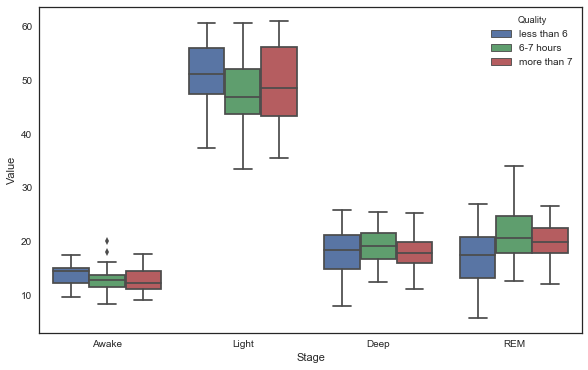

In [52]:
fig=plt.figure(figsize=(6*1.62,6))
sns.set(style="white")
sns.boxplot(x='Stage', y='Value',hue='Quality',order=['Awake','Light','Deep','REM'],
            hue_order=['less than 6', '6-7 hours', 'more than 7'], data=stageall);
plt.savefig('stageboxplot.png',bbox_inches='tight')

<img src='stageboxplot.png' alt='boxplot of the sleep stages orders by quality' class='center'>
Sleeping for a fair amount of time actually means that you end up spending less amount of time awake in bed. Sleeping for 6-7 hours actually gives you a marginal advantage in Deep and REM sleep over sleep sleeping less and more.

## Conclusion
* Ideally, Niyati should sleep for 6-7 hours everynight with total time time in bed around 7 1/2 hours.
* Ideal Bedtime is half hour before or after midnight depending on when she plans to wake up.
* The best quality of sleep will have higher percentages of REM and Deep sleep